In [39]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm
import os
import re
import networkx as nx
import copy
import jellyfish as j
from itertools import combinations
import matplotlib as mpl
import matplotlib.dates as mdates
from datetime import datetime

# retriving the data downloaded priviously

In [40]:
# import submissions data
data_submissions = pd.read_pickle('data/submissions.pkl')

data_submissions['body'] = data_submissions['title'].copy()
data_submissions['parent_id'] = data_submissions['id'].copy()
data_submissions['link_id'] = data_submissions['id'].copy()
data_submissions['is submission'] = np.full(len(data_submissions), True)


In [41]:
# import comments data
data_comments = pd.read_pickle('data/comments.pkl')

# clean ids
data_comments['link_id'] = [id.split('_')[1] for id in data_comments['link_id']]
data_comments['parent_id'] = [id.split('_')[1] for id in data_comments['parent_id']]

data_comments['is submission'] = np.full(len(data_comments), False)


# Concatenate the two data sets

Now a submission is counted as a comment, and all comments on a submission counts as a reply to a comment

In [42]:
data_columns = ['author', 'body', 'created_utc', 'id', 'parent_id', 'link_id', 'subreddit', 'subreddit_id', 'is submission']

data = pd.concat([data_submissions[data_columns], data_comments[data_columns]], ignore_index=True)

# convert timestamp to readable time
to_readable_time = lambda timestamp: datetime.fromtimestamp(timestamp).strftime("%d-%b-%Y (%H:%M:%S)")
data['readable_time'] = list(map(to_readable_time, data['created_utc']))

# clean bodies to be alphanumeric and spaces only
to_readable_text = lambda s: re.sub(r'[^A-Za-z0-9 ]+', '', s)
data['title'] = list(map(to_readable_text, data['body']))

In [43]:
# Becuase the API isn't 100% accurate, some comments are lost, comments which parent comment
# aren't in our dataset, will get the original submission as their parent comment

known = set(data['id'])
mask = np.array([id in known for id in data['parent_id']])

print(f"Data with known parents: {100*(mask).sum()/len(data):.4}%")
print("The rest had their parrent_id set to the link_id (submission)")

data['parent_id'] = [parent_id if known else link_id for (parent_id,known,link_id) in zip(data['parent_id'], mask, data['link_id'])]

Data with known parents: 99.52%
The rest had their parrent_id set to the link_id (submission)


# Bot analysis

In [44]:
# create dataframe grouped by author

author_cols = ['author', 'body', 'subreddit', 'is submission']
unique_subreddits = list(np.unique(data['subreddit']))

# add columns to see which subreddit is has been posted in
data_author = data.copy()
for subreddit in unique_subreddits:
    data_author[subreddit] = np.array(data_author['subreddit'] == subreddit, dtype=int)

data_author['n_comments'] = np.ones(len(data_author))

# aggregate the data grouped by the author name
aggregation_dict = dict()
aggregation_dict['body'] = list
aggregation_dict['n_comments'] = 'count'
aggregation_dict.update({s: np.mean for s in ['is submission'] + unique_subreddits})

# we now have a dataset with all comments made by a single author and
# how active they are in each of the listed subreddit and submission/comment ratio
data_author = data_author.groupby('author').agg(aggregation_dict)
data_author.drop('[deleted]', inplace=True)

In [45]:
# Method one, simple linear decision boundary
data_author['most_copied_comment'] = [np.unique(data_author['body'][author], return_counts=True)[1].max()
                                        for author in data_author.index]

data_author['is_bot_linear'] = 0.2 * data_author['n_comments'] + 2 < data_author['most_copied_comment']

# Method two, mean jaro distance and more than n comments
mean_text_similarity = lambda author: np.mean([j.jaro_distance(*bodys) 
                                               for bodys in combinations(data['body'][data['author'] == author], 2)])

data_author['mean_jaro'] = [mean_text_similarity(author) for author in tqdm(data_author.index)]
data_author['mean_jaro'].fillna(0, inplace=True)

data_author['is_bot_jaro'] = (0.65 < data_author['mean_jaro']) & (10 <= data_author['n_comments'])

data_author['is_bot'] = data_author['is_bot_linear'] | data_author['is_bot_jaro']

  0%|          | 0/64975 [00:00<?, ?it/s]C:\Users\niels\anaconda3\envs\SocialScience\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\niels\anaconda3\envs\SocialScience\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 64975/64975 [13:48<00:00, 78.39it/s] 


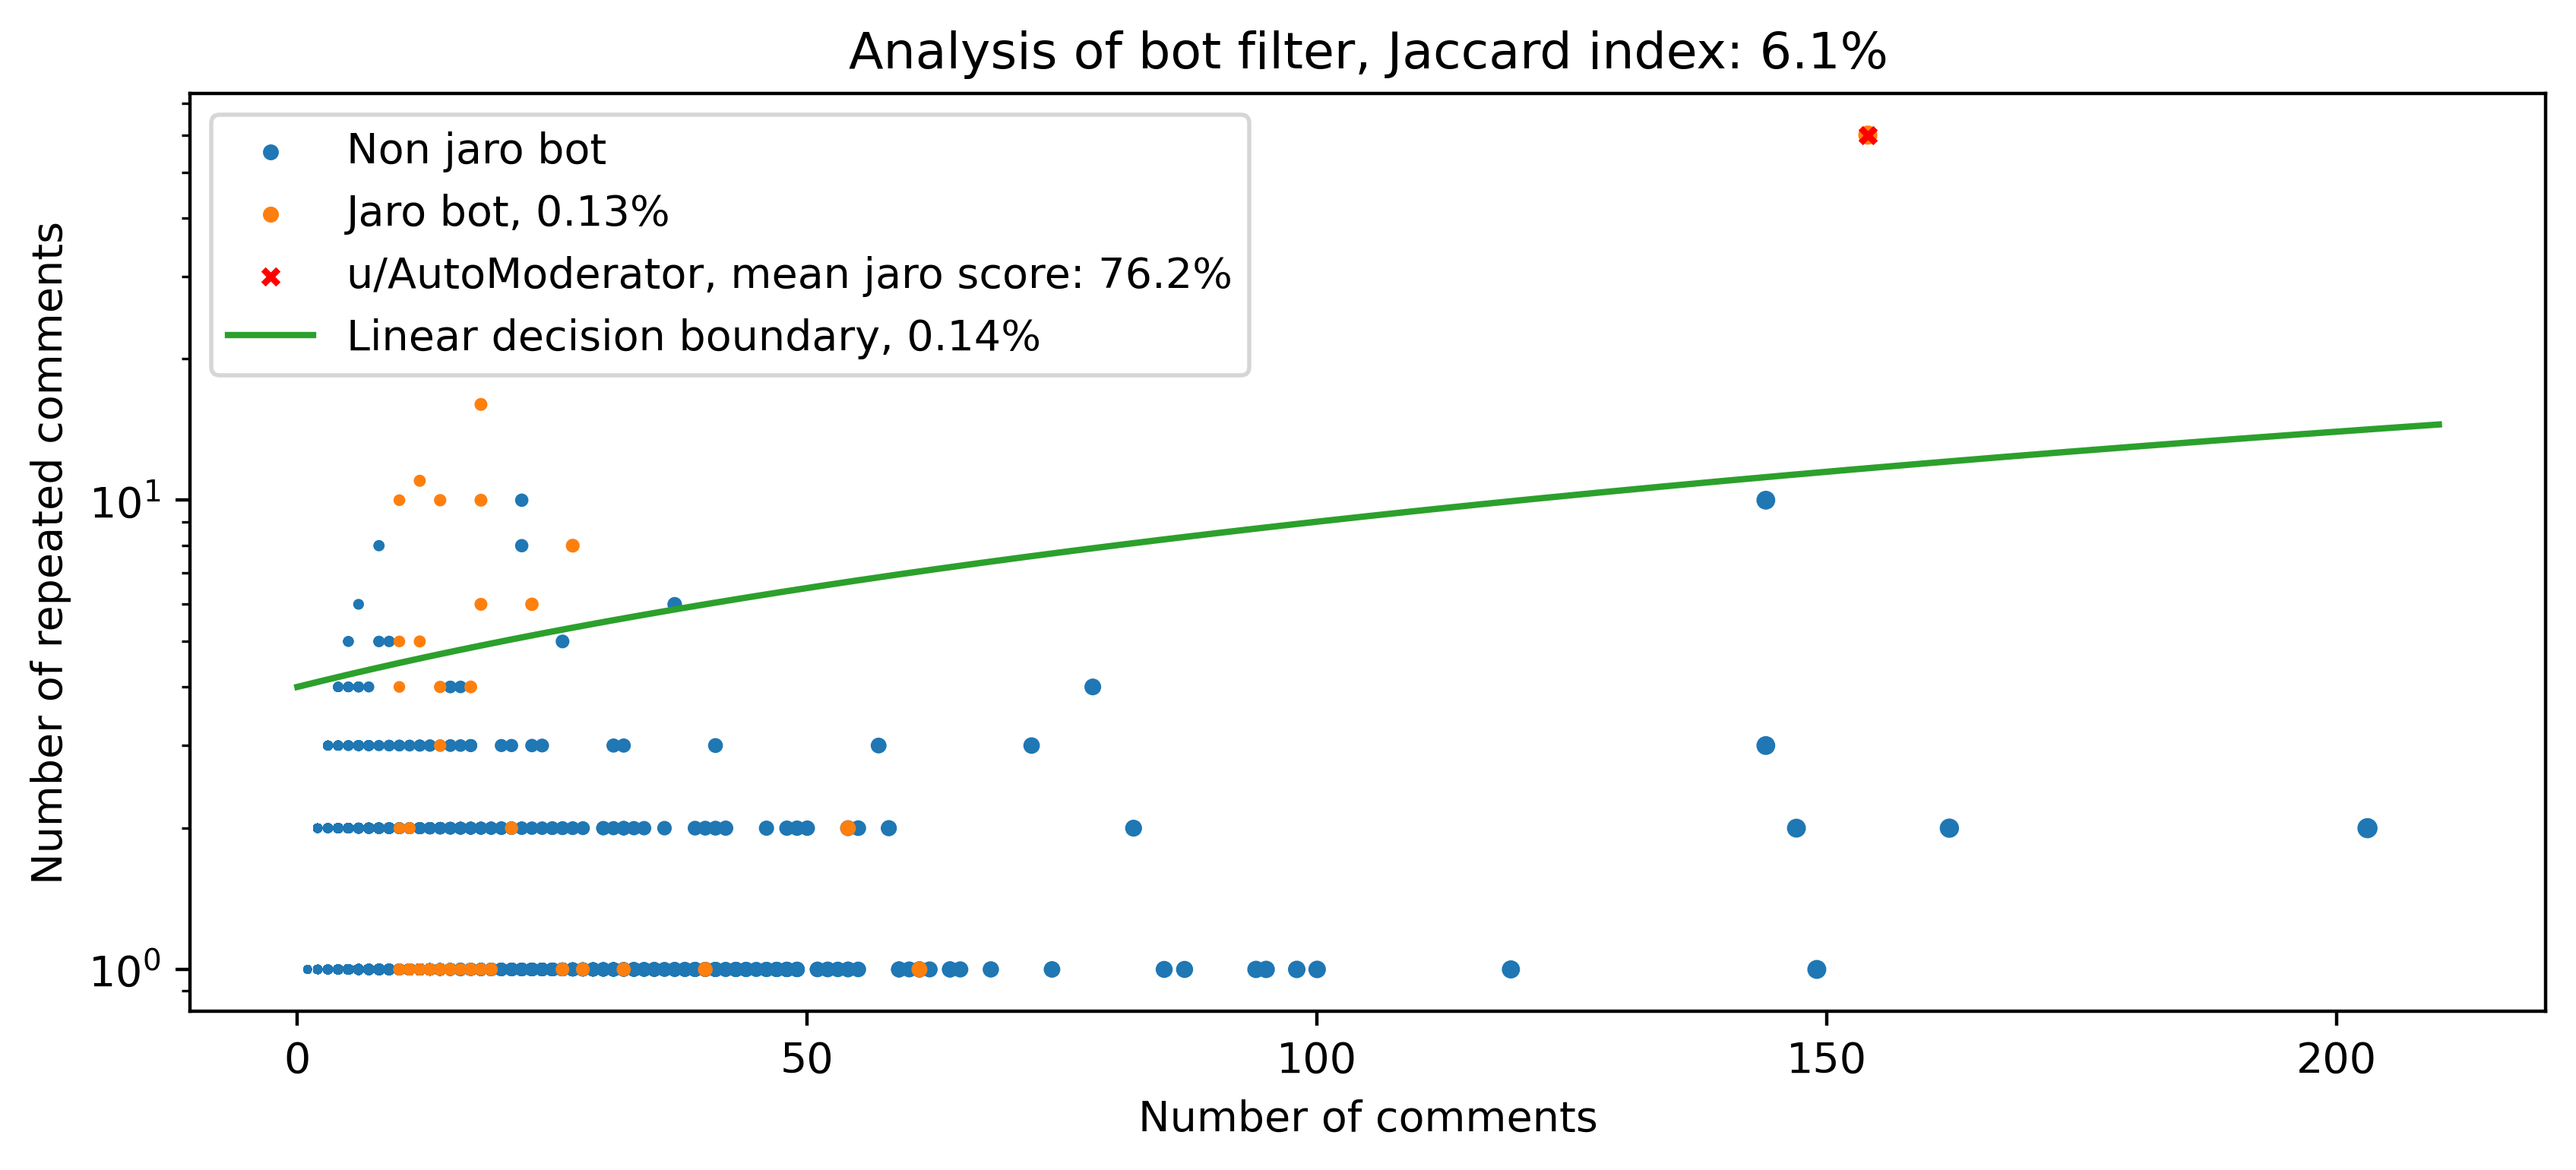

In [46]:
fig, ax = plt.subplots(figsize=(10,4), dpi=400)

# plot datapoints that is not counted as bots by jaro score
ax.scatter(data_author['n_comments'][~data_author['is_bot_jaro']],
           data_author['most_copied_comment'][~data_author['is_bot_jaro']],
           s=np.sqrt(data_author['n_comments'][~data_author['is_bot_jaro']]),
           label='Non jaro bot')

# plot datapoints that is counted as bots by jaro score
ax.scatter(data_author['n_comments'][data_author['is_bot_jaro']],
           data_author['most_copied_comment'][data_author['is_bot_jaro']],
           s=np.sqrt(data_author['n_comments'][data_author['is_bot_jaro']]),
           label=f"Jaro bot, {100 * data_author['is_bot_jaro'].mean():.2}%")

# show u/AutoModerator in plot
ax.scatter(data_author['n_comments'][data_author.index == 'AutoModerator'],
           data_author['most_copied_comment'][data_author.index == 'AutoModerator'],
           s=np.sqrt(data_author['n_comments'][data_author.index == 'AutoModerator']),
           marker='x',
           c='red',
           label=f"u/AutoModerator, mean jaro score: {100 * float(data_author['mean_jaro'][data_author.index == 'AutoModerator']):.1f}%")

# plot decision boundary
xs = np.linspace(0, 210, 1000)
ax.plot(xs, 0.05 * xs + 4, c='C2', label=f"Linear decision boundary, {100 * data_author['is_bot_linear'].mean():.2}%")

# jaccard similarity for fun
jaccard_similarity = (data_author['is_bot_jaro'] & data_author['is_bot_linear']).sum() / \
                     (data_author['is_bot_jaro'] | data_author['is_bot_linear']).sum()
ax.set_title(f'Analysis of bot filter, Jaccard index: {100 * jaccard_similarity:.2}%')
ax.set_xlabel('Number of comments')
ax.set_ylabel('Number of repeated comments')
ax.set_yscale('log')
plt.legend()
plt.show()

In [47]:
# define all bots
data_author['is_bot'] = data_author['is_bot_linear'] | data_author['is_bot_jaro']

bot_lookup = {author: data_author['is_bot'][author] for author in data_author.index}
bot_lookup['[deleted]'] = False

# find all comments made by bots, which aren't submissions
is_bot = np.array([bot_lookup[author] for author in data['author']])
data['to_remove'] = is_bot & ~data['is submission']

# if a comments parent points to a bot comment, movde the pointer to the parent of the bot comment recursively
lookup_data = data.set_index('id')
def get_alive_parent(id):
    parent = lookup_data.loc[id]['parent_id']
    while lookup_data.loc[parent]['to_remove']:
        parent = lookup_data.loc[parent]['parent_id']
    return parent

data['parent_id'] = [get_alive_parent(id) for id in tqdm(data['id'])]

# remove bot comments which aren't submissions
print(f"Removed {data['to_remove'].sum()} datapoints, equvalent to {100*data['to_remove'].mean():.3}%")
data = data[~data['to_remove']]

100%|██████████| 189903/189903 [00:36<00:00, 5163.59it/s]


Removed 1536 datapoints, equvalent to 0.809%


# Analysis of subject of comment

In [48]:
# find the subject in each text
q_smith = re.compile('smith')
q_chris1 = re.compile('chris')
q_chris2 = re.compile('rock')
q_slap = re.compile('slap')
q_oscar = re.compile('oscar')
q_jada1 = re.compile('jada')
q_jada2 = re.compile('pinkett')

list_will, list_chris, list_slap, list_oscar, list_jada = [], [], [], [], []
for text in data['title'].to_list():
    text = text.lower()
    # if jada or pinkett is mentioned, Jada Pinkett subject is true for that comment
    list_will.append(bool(q_smith.search(text)))
    list_chris.append(bool(q_chris1.search(text)) | bool(q_chris2.search(text)))
    list_slap.append(bool(q_slap.search(text)))
    list_oscar.append(bool(q_oscar.search(text)))
    list_jada.append(bool(q_jada1.search(text)) | bool(q_jada2.search(text)))

data['Will Smith'] = list_will
data['Chris Rock'] = list_chris
data['slap'] = list_slap
data['oscar'] = list_oscar
data['Jada Pinkett'] = list_jada

# Trickle down subjects

If a parent subject has a specifik subject, the whole subtree of children comments will inherit this subject. This makes sure that on comments talking about the oscar awards, we can filter to only get comments regarding the slap. This also helps classify comments like:

Parent: "Smith really did overreact"
Child:      "Yeah, he can't even take a joke"

In [49]:
# Reverse tree as notes now only points at their parents

child_dict = {key: list() for key in data['id']}

for id, parent_id in zip(data['id'], data['parent_id']):
    if id != parent_id:
        child_dict[parent_id].append(id)

data['child_ids'] = [child_dict[id] for id in data['id']]

In [50]:
# DFS algorithm to trickle down subjects to child nodes

subjects = ['Will Smith', 'Chris Rock', 'slap', 'oscar', 'Jada Pinkett']

# initialize the algorithm with the submissions
root_ids = data['id'][data['is submission'] == True].to_list()

# create a data structure for the algorithm
create_id_dict = lambda subject: {id: bool_val for id, bool_val in zip(data['id'],data[subject])}
subject_dict = {subject: create_id_dict(subject) for subject in subjects}
subject_dict['children'] = {id: chridren for id, chridren in zip(data['id'], data['child_ids'])}

In [51]:
# check to make sure our data is a tree 
parent_graph = nx.DiGraph()
for id in data['id']:
    parent_graph.add_node(id)

for child_id, parent_id in zip(data['id'], data['parent_id']):
    if child_id != parent_id:
        parent_graph.add_weighted_edges_from([(child_id, parent_id, 1)])
parent_cycles = list(nx.simple_cycles(parent_graph))

child_graph = nx.DiGraph()
for id in data['id']:
    child_graph.add_node(id)

for parent_id, child_ids in child_dict.items():
    for child_id in child_ids:
        child_graph.add_weighted_edges_from([(child_id, parent_id, 1)])
children_cycles = list(nx.simple_cycles(child_graph))

if len(parent_cycles) + len(children_cycles):
    print("Not a tree")
    raise

In [52]:
print(f"Longest chain of comments in data: {nx.dag_longest_path_length(child_graph)}")

Longest chain of comments in data: 55


In [53]:
# difine our DFS trickle down subjects algorithm:
def DFS_algorithm(ids, subject, counter, ids_visited):
    for id in ids:
        if id not in ids_visited:
            counter += 1
            ids_visited.add(id)
            parent_subject = subject_dict[subject][id]
            child_ids = subject_dict['children'][id]
            for child_id in child_ids:
                child_subject = subject_dict[subject][child_id]
                subject_dict[subject][child_id] = child_subject | parent_subject
                counter = DFS_algorithm(child_ids, subject, counter=counter, ids_visited=ids_visited)
    else:
        return counter


In [54]:
# check to make sure our algorithm changes stuff
subject_dict_old = copy.deepcopy(subject_dict)

# run algorithm for each subject
for subject in tqdm(subjects):
    visited_notes = DFS_algorithm(root_ids, subject, 0, set())
    # print(subject, visited_notes)


# 1000 random tests to see if subject_dict changed
counter = 0
for _ in range(1000):
    subject, id = np.random.choice(subjects), np.random.choice(data['id'])
    if subject_dict_old[subject][id] != subject_dict[subject][id]:
        counter += 1
        # print(subject, id)
        # print(subject_dict_old[subject][id], subject_dict[subject][id])
if not counter:
    print("Subject dict did not change")

# Filter data

We made a broad query on our data, words like slap could be used in many other settings than ours. Also the has been lots of discussions regarding the oscars overall, not just the slap. We therefore only want subjects containing either the three people in the incident, or comments that mention both the slap and the oscars.

The reason for this whole trickle down subjects is, that there might be post regarding the oscars in generel, where ceartain comment threds mention the slap.

In [55]:
query = lambda df: df['Will Smith'] | df['Chris Rock'] | df['Jada Pinkett'] | (df['slap'] & df['oscar'])

relavant = query(data)
print(f"Relavant before trickle down subjects: {100*relavant.sum()/len(relavant):.4}%")

for subject in subjects:
    data[subject] = [subject_dict[subject][id] for id in data['id']]

relavant = query(data)
print(f"Relavant after trickle down subjects: {100*relavant.sum()/len(relavant):.4}%")

Relavant before trickle down subjects: 21.05%
Relavant after trickle down subjects: 61.22%


In [56]:
data_relavant = data[relavant].copy()

# since we have removed data, we want to make sure, that all comments still has parent comments for network analysis
parent_ids = {id: parent_id for id, parent_id in zip(data_relavant['id'], data_relavant['parent_id'])}

known_ids = set(data_relavant['id'])
for id, parent_id in zip(data_relavant['id'], data_relavant['parent_id']):
    if parent_id not in known_ids:
        parent_ids[id] = id

data_relavant['parent_id'] = [parent_ids[id] for id in data_relavant['id']]

# save cleaned data
data_relavant.to_pickle('data/data_cleaned.pkl')

# Data analysis

In [69]:
hourly_value = data_relavant.groupby('date').agg({'author': ('count', list)})['author']

In [71]:
hourly_value = data_relavant.groupby('date').agg({'author': ('count', list)})['author']
daily_value = hourly_value['count'].rolling(24, center=True).mean()

In [76]:
hourly_value

,count,list
date,,
2022 03 28-00,6,"[amnesiac7, Holland1954, MR_TELEVOID, TheShall..."
2022 03 28-01,14,"[Ac997, royaltrux, dbadefense1990, ZeppoBro, T..."
2022 03 28-02,7,"[[deleted], Ramonzmania, tkatt3, Metroid37, [d..."
2022 03 28-03,23,"[kkurani09, [deleted], texachusetts, SonOfZakn..."
2022 03 28-04,1672,"[snuffdontknow, nOMnOMShanti, Bel_Air_Fresh, k..."
...,...,...
2022 04 26-02,2,"[[deleted], [deleted]]"
2022 04 26-11,1,[[deleted]]
2022 04 27-06,1,[Firelight_scout]


In [78]:
hourly_value['list'].rolling(24, center=True).agg(lambda my_list: list(*my_list))

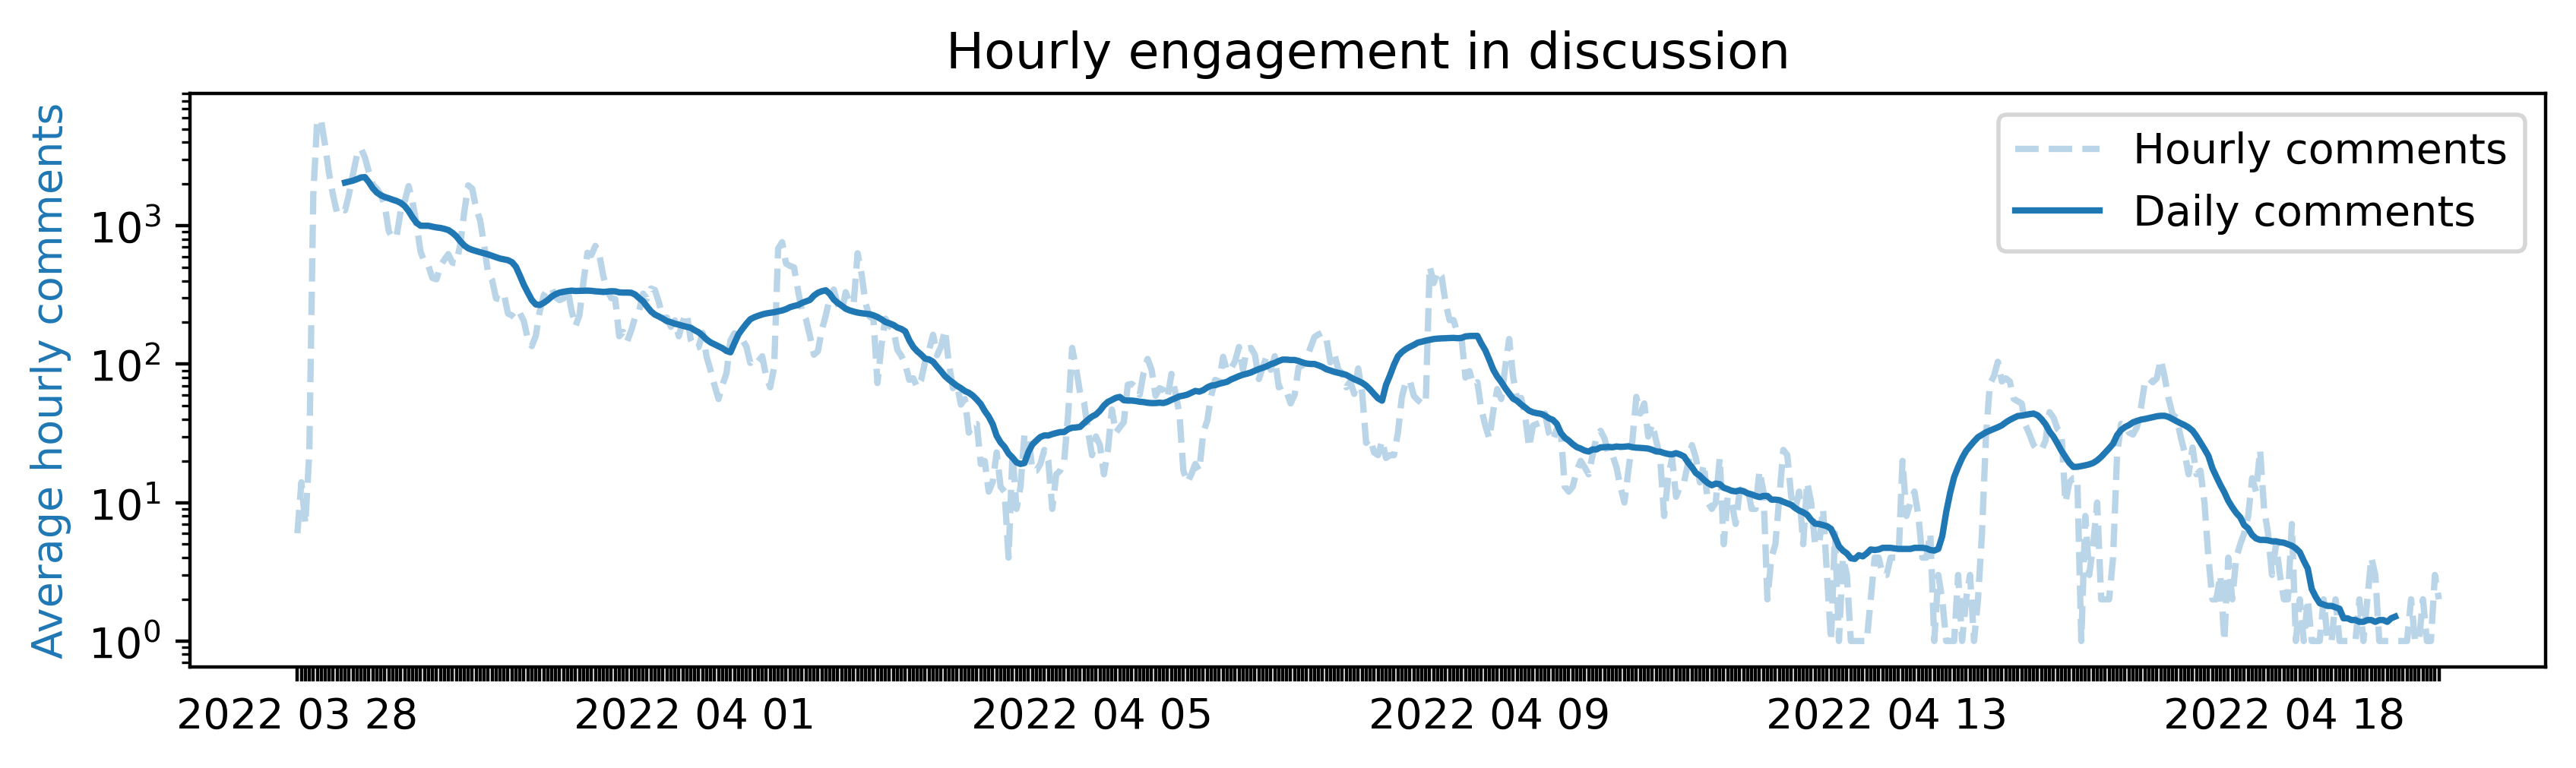

In [73]:
# Get hourly data
data_relavant['date'] = [datetime.fromtimestamp(timestamp).strftime('%Y %m %d-%H') for timestamp in data_relavant['created_utc']]
hourly_value = data_relavant.groupby('date').agg({'author': ('count', list)})['author']

# Get daily data
data_relavant['date'] = [datetime.fromtimestamp(timestamp).strftime('%Y %m %d') for timestamp in data_relavant['created_utc']]
daily_value = data_relavant.groupby('date').agg({'author': ('count', list)})['author']


fig, ax  = plt.subplots(figsize=[10, 2.5], dpi=400)

# plot hourly values
ax.plot(hourly_value.index, hourly_value['count'], ls='--', alpha=0.3, label="Hourly comments")

# plot daily values
daily_value = hourly_value['count'].rolling(24, center=True).mean()
get_ind = lambda numElems: np.round(np.linspace(0, len(hourly_value.index) - 1, numElems)).astype(int)
ax.plot(daily_value.index, daily_value, color='C0', label="Daily comments")
# ax.plot(hourly_value.index[get_ind(len(daily_value['count']))], daily_value['count']/24, color='C0', label="Daily comments")

# number of unique users active that day
# ax2 = ax.twinx()
# unique_daily = daily_value['list'].apply(lambda list: len(np.unique(list)))
# ax2.plot(daily_value.index, unique_daily, color='C1', label="Daily unique users")
# ax2.set_yscale('log')


# format plot
myFmt = lambda i, _: hourly_value.index[i][:-3]
ax.xaxis.set_major_formatter(myFmt)
every_nth = 100
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

ax.set_title("Hourly engagement in discussion")
ax.set_yscale('log')

ax.set_ylabel("Average hourly comments", c='C0')
ax.legend(loc='upper right')

# ax2.legend(loc='center right')
# ax2.set_ylabel("Average active authors", c='C1')
plt.show()

In [ ]:
# creating barplot cointaining the percont of comments related to each subject
fig, ax = plt.subplots(figsize=(6,3), dpi=400)
plt.grid(b=None, which='major', axis='y', alpha=0.3)

ax.bar(subjects, [100*data_relavant[subject].mean() for subject in subjects], width=0.3)
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())

ax.set_title('Percent of comments containing each subject')

plt.show()

In [ ]:
# creating histogram showing the distribution of n_aurthor comments
fig, ax = plt.subplots(figsize=(6,3), dpi=400)
ax.hist(data_relavant.groupby('author')['id'].count().drop('[deleted]'))
ax.set_yscale('log')

ax.set_title("Number of comments by each author")
ax.set_xlabel('Number of comments')
ax.set_ylabel('Count of authors')
plt.show()

In [ ]:
(data_relavant['author'] == '[deleted]').mean()

0.19863678934406326